In [1]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Yannis Laaroussi - Fabio Palmisano -*-
# -*- date : 2024-03-15 -*-
# -*- Last revision: 2024-03-15 (Vincent Roduit)-*-
# -*- python version : 3.11.7 -*-
# -*- Description: Notebook that summarizes results-*-

# <center> COM - 480: Data Visualization</center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center> Olympic Games Visualization </center>
---

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
# import plotly.express as px
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Web Scrapping
import requests
from bs4 import BeautifulSoup
import shutil
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time

# 1. Load Data

You can download the Data from this website:

In [2]:
DATA_PATH = "../../data/"
df_athletes = pd.read_csv(os.path.join(DATA_PATH, 'olympic_athletes.csv'))
df_hosts = pd.read_csv(os.path.join(DATA_PATH, 'olympic_hosts.csv'))
df_medals = pd.read_csv(os.path.join(DATA_PATH, 'olympic_medals.csv'))
df_results = pd.read_csv(os.path.join(DATA_PATH, 'olympic_results.csv'))

# 2. Preliminary Analysis

## 2.1 athletes

In [4]:
df_athletes.head(10)

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000.0,NaN,NaN
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995.0,NaN,NaN
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993.0,NaN,NaN
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995.0,NaN,NaN
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989.0,NaN,NaN
5,https://olympics.com/en/athletes/matt-graham,Matt GRAHAM,3,Sochi 2014,1994.0,\r\n\r\n\r\n1\r\n\r\nS\r\n\r\n,NaN
6,https://olympics.com/en/athletes/ikuma-horishima,Ikuma HORISHIMA,2,PyeongChang 2018,1997.0,\r\n\r\n\r\n1\r\n\r\nB\r\n\r\n,NaN
7,https://olympics.com/en/athletes/daichi-hara,Daichi HARA,2,PyeongChang 2018,1997.0,\r\n\r\n\r\n1\r\n\r\nB\r\n\r\n,NaN
8,https://olympics.com/en/athletes/laurent-dumais,Laurent DUMAIS,1,Beijing 2022,1996.0,NaN,NaN
9,https://olympics.com/en/athletes/james-matheson,James MATHESON,2,PyeongChang 2018,1995.0,NaN,NaN


In [5]:
df_athletes.describe()

,games_participations,athlete_year_birth
count,75904.000000,73448.000000
mean,1.535874,1961.619377
std,0.854563,28.129576
min,0.000000,1836.000000
25%,1.000000,1946.000000
50%,1.000000,1968.000000
75%,2.000000,1983.000000
max,10.000000,2009.000000


### Athletes participations

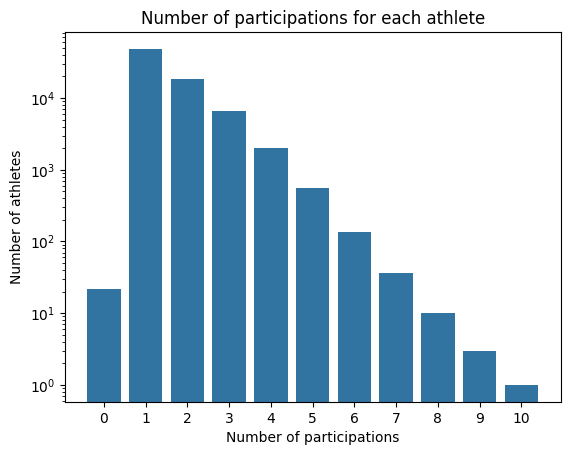

In [6]:
# Plot the number of participation for each athlete
participations = df_athletes['games_participations'].value_counts().reset_index()
sns.barplot(x='games_participations', y='count', data=participations)
plt.title('Number of participations for each athlete')
plt.xlabel('Number of participations')
plt.ylabel('Number of athletes')
plt.semilogy()
plt.show()

## 2.2 Hosts

In [7]:
df_hosts.head(5)

,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year
0,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
1,tokyo-2020,2021-08-08T14:00:00Z,2021-07-23T11:00:00Z,Japan,Tokyo 2020,Summer,2020
2,pyeongchang-2018,2018-02-25T08:00:00Z,2018-02-08T23:00:00Z,Republic of Korea,PyeongChang 2018,Winter,2018
3,rio-2016,2016-08-21T21:00:00Z,2016-08-05T12:00:00Z,Brazil,Rio 2016,Summer,2016
4,sochi-2014,2014-02-23T16:00:00Z,2014-02-07T04:00:00Z,Russian Federation,Sochi 2014,Winter,2014


In [8]:
#Number of olympic games 
nb_games = df_hosts['game_slug'].nunique()
nb_locations = df_hosts['game_location'].nunique()
print(f'There are {nb_games} different Olympic games and {nb_locations} different countries that hosted the games')

There are 53 different Olympic games and 26 different countries that hosted the games


### Plot Hostings per country

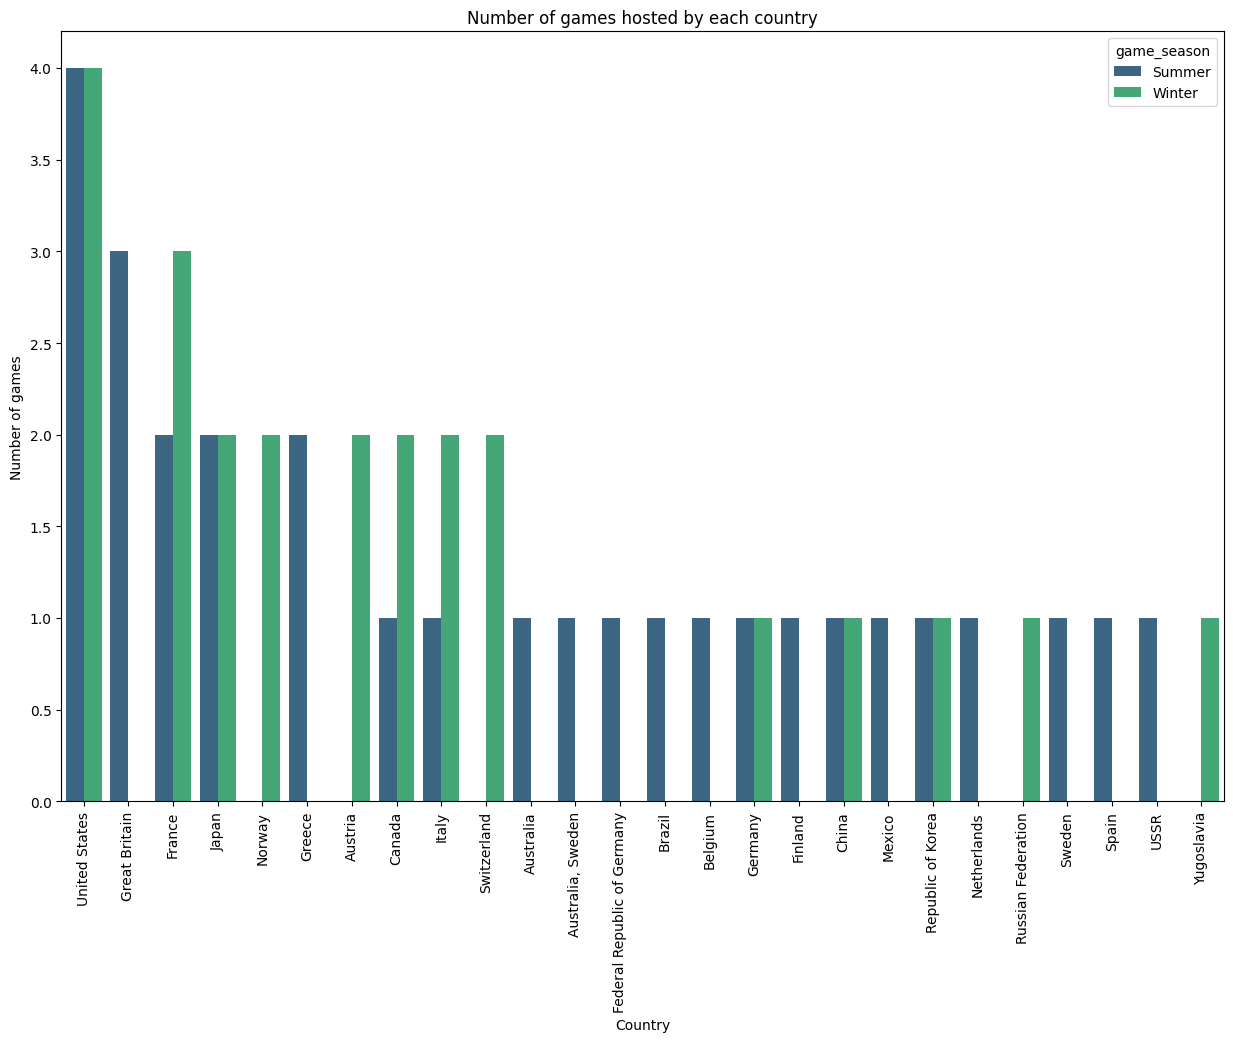

In [9]:
#Number of games hosted by each country
plt.figure(figsize=(15, 10))
games_by_country = df_hosts[['game_location','game_season']].value_counts().reset_index()
sns.barplot(data=games_by_country, x='game_location',y='count',hue='game_season', palette='viridis')
plt.title('Number of games hosted by each country')
plt.xlabel('Country')
plt.ylabel('Number of games')
plt.xticks(rotation=90)
plt.show()

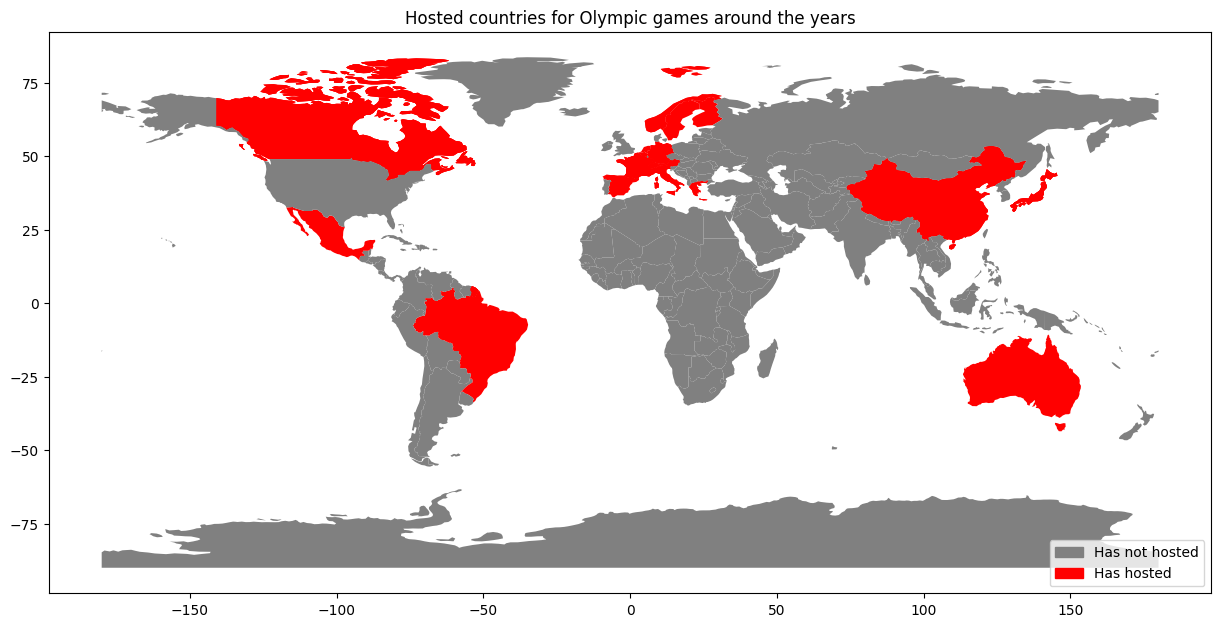

In [10]:
hosts = df_hosts.copy()
cmap = ListedColormap(['grey', 'red'])
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Get the world geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Make a dataframe with only the country and the year of the games + country in 3 letters
hosts = hosts[['game_year','game_location','game_season']].drop_duplicates()
hosts = hosts.merge(world[['name','iso_a3']], left_on='game_location', right_on='name')
hosts = hosts.drop(columns=['name'])

# Merge world and hosts dataframes
hosts = world.merge(hosts, how='outer', on='iso_a3')

# Fill NaN values with a default value
hosts['game_year'] = hosts['game_year'].fillna(0)

# Plot result in world map around the years

# Create the legend patches
legend_labels = {0: 'Has not hosted', 1: 'Has hosted'}
patches = [mpatches.Patch(color=color, label=label)
           for color, label in zip(['gray', 'red'], legend_labels.values())]

# Add the legend to the plot
plt.legend(handles=patches, loc='lower right')
hosts.plot(column='game_year', ax=ax, cmap=cmap, 
                  legend_kwds={'label': "Year of the games", 'orientation': "horizontal"})
plt.title('Hosted countries for Olympic games around the years')
plt.show()

## 2.3 Medals

In [11]:
df_medals = df_medals.merge(df_hosts, left_on='slug_game', right_on='game_slug')

In [12]:
df_medals.head(5)

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022


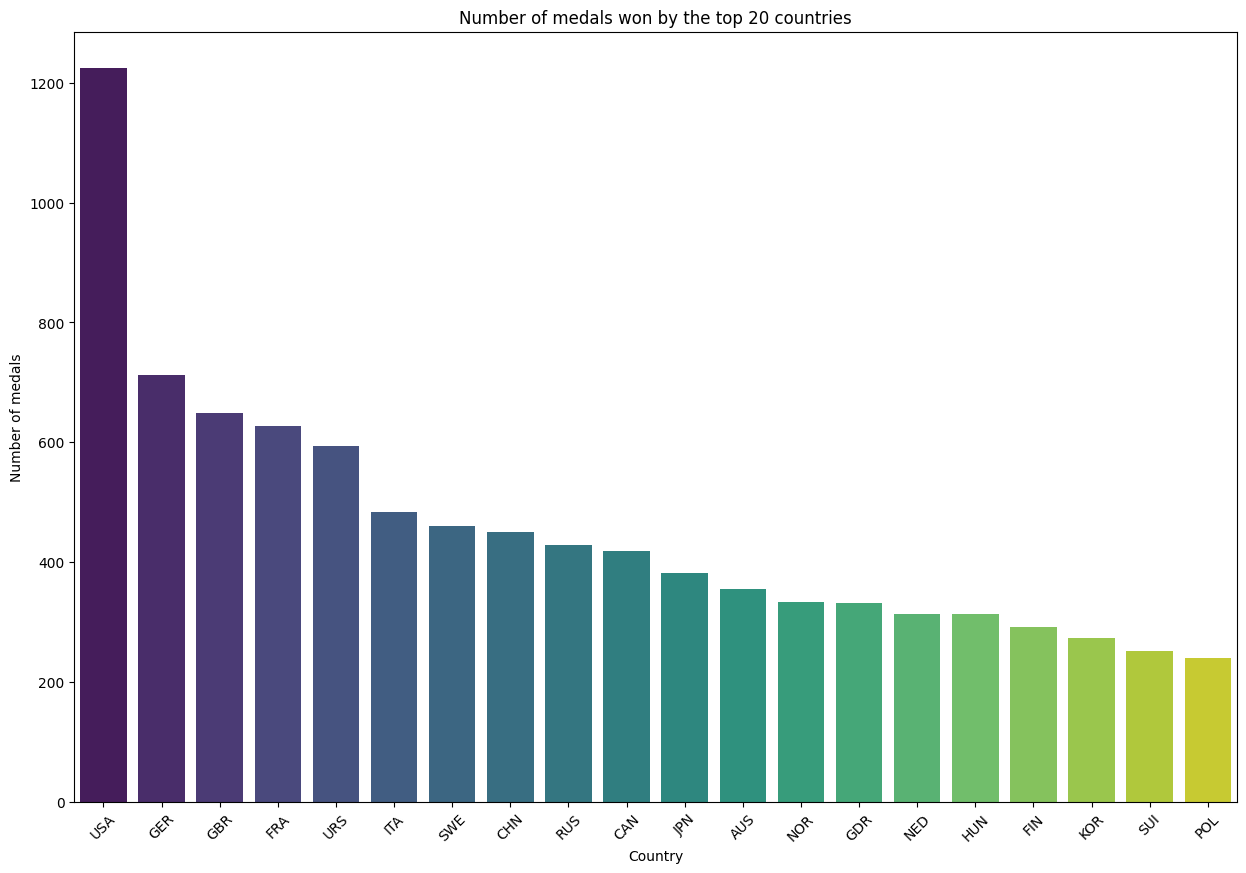

In [13]:
#Number of medals won by each country
plt.figure(figsize=(15, 10))
#Count only medal for team events
medals_by_country = df_medals.drop_duplicates(subset=['medal_type','participant_type','event_title','discipline_title','country_3_letter_code'])
medals_by_country = medals_by_country['country_3_letter_code'].value_counts().reset_index().sort_values(by='count', ascending=False)
sns.barplot(data=medals_by_country.head(20), x='country_3_letter_code',y='count', palette='viridis')
plt.title('Number of medals won by the top 20 countries')
plt.xlabel('Country')
plt.ylabel('Number of medals')
plt.xticks(rotation=45)
plt.show()

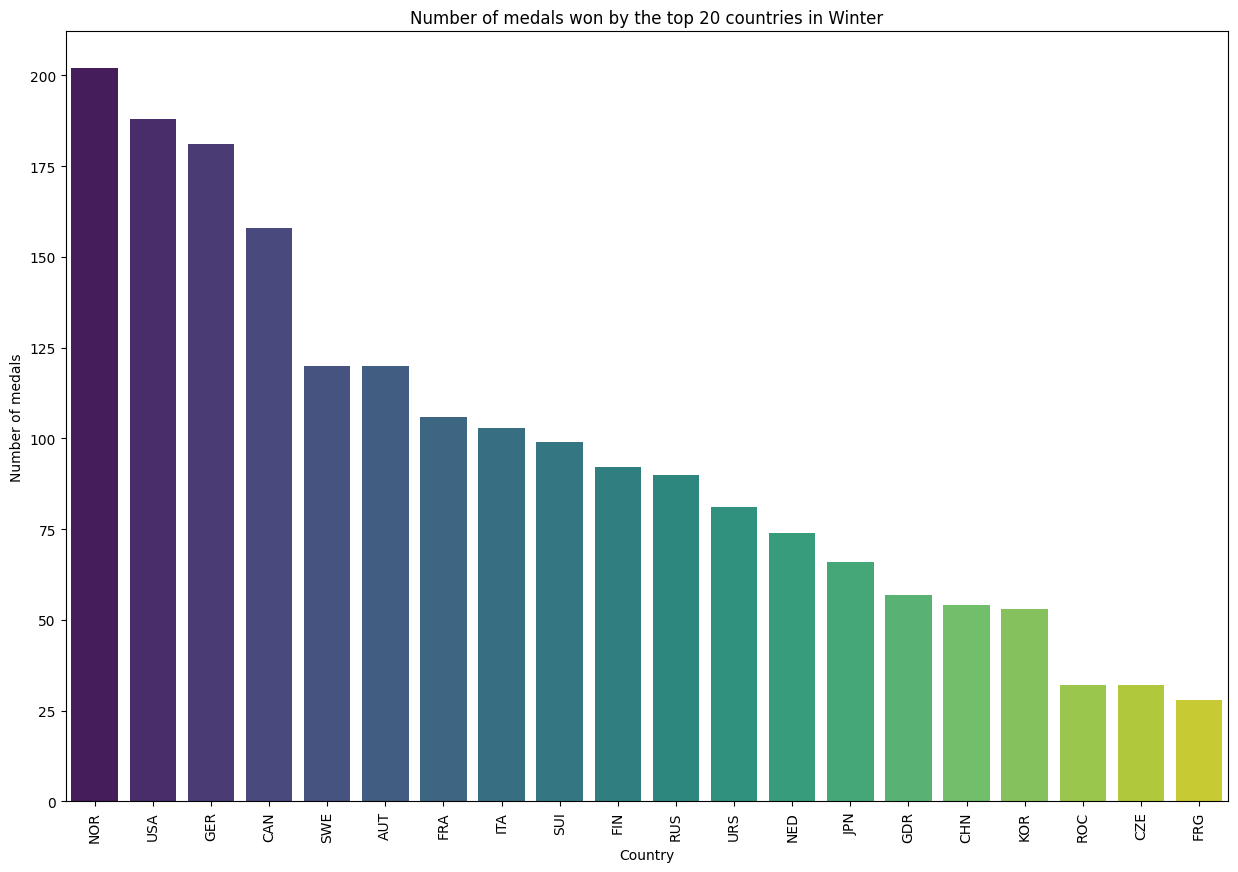

In [14]:
#Number of medals won by each country in Winter
plt.figure(figsize=(15, 10))
medals_by_country = df_medals.drop_duplicates(subset=['medal_type','participant_type','event_title','discipline_title','country_3_letter_code'])
medals_by_country_winter = medals_by_country[['country_3_letter_code','game_season']].query('game_season == "Winter"')
medals_by_country_winter = medals_by_country_winter['country_3_letter_code'].value_counts().reset_index().sort_values(by='count', ascending=False)
sns.barplot(data=medals_by_country_winter.head(20), x='country_3_letter_code',y='count', palette='viridis')
plt.title('Number of medals won by the top 20 countries in Winter')
plt.xlabel('Country')
plt.ylabel('Number of medals')
plt.xticks(rotation=90)
plt.show()

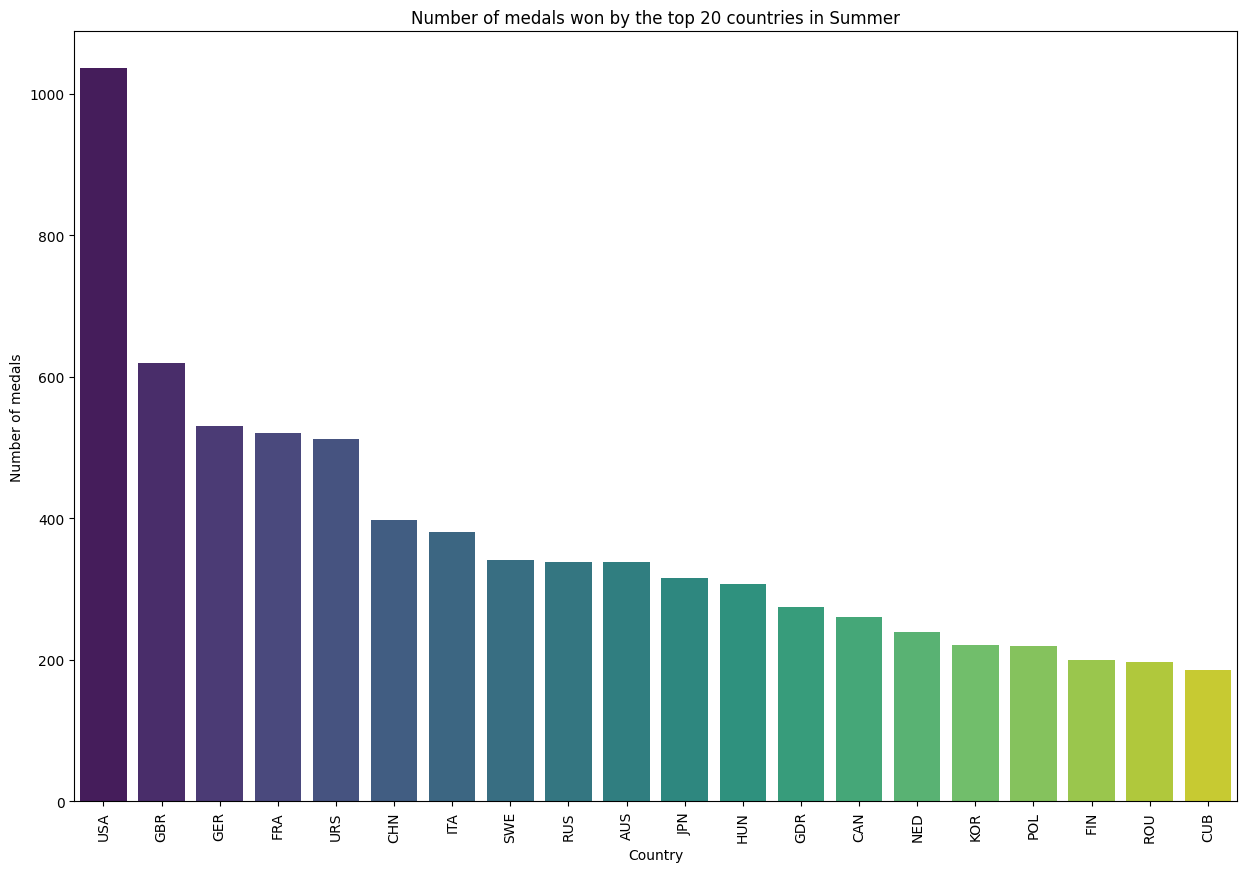

In [15]:
#Number of medals won by each country in Summer
plt.figure(figsize=(15, 10))
medals_by_country_summer = df_medals.drop_duplicates(subset=['medal_type','participant_type','event_title','discipline_title','country_3_letter_code'])
medals_by_country_summer = medals_by_country_summer[['country_3_letter_code','game_season']].query('game_season == "Summer"')
medals_by_country_summer = medals_by_country_summer['country_3_letter_code'].value_counts().reset_index().sort_values(by='count', ascending=False)
sns.barplot(data=medals_by_country_summer.head(20), x='country_3_letter_code',y='count', palette='viridis')
plt.title('Number of medals won by the top 20 countries in Summer')
plt.xlabel('Country')
plt.ylabel('Number of medals')
plt.xticks(rotation=90)
plt.show()

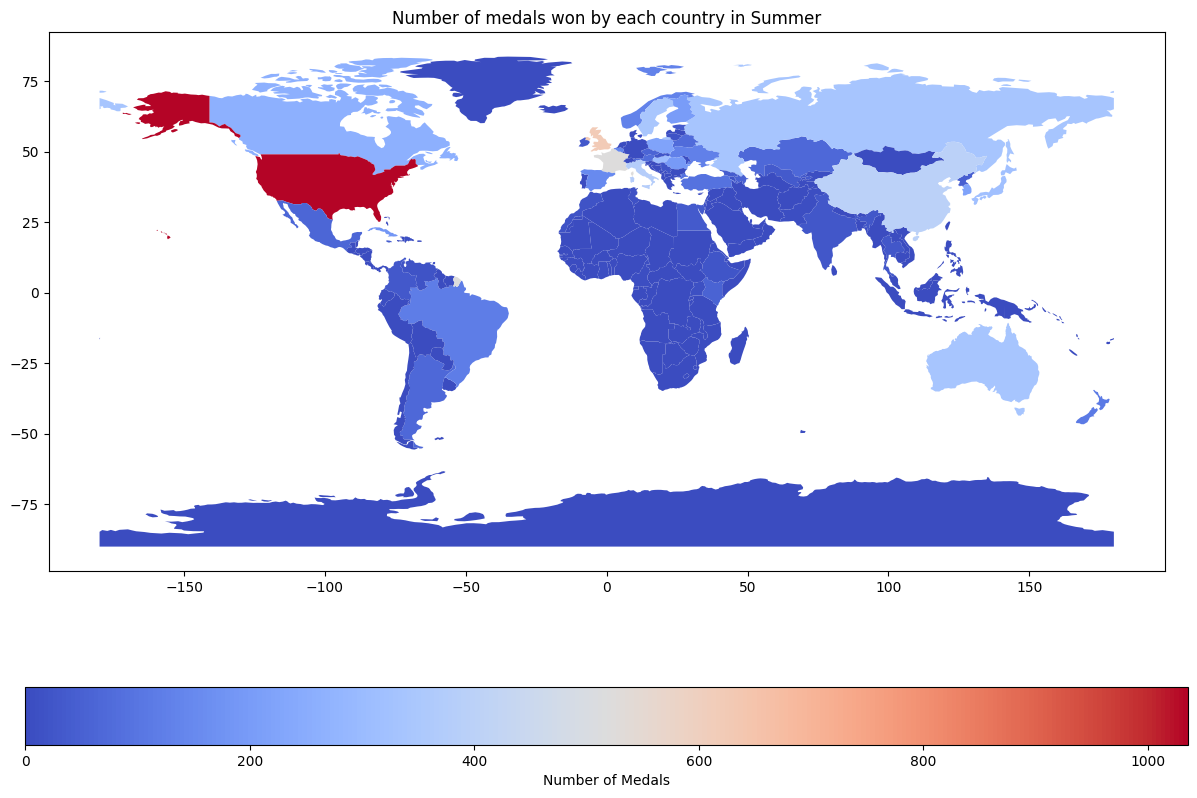

In [16]:
# Get the world geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

medals_by_country_summer.rename(columns={'country_3_letter_code': 'iso_a3'}, inplace=True)

world_medals = world.merge(medals_by_country_summer, how='left', on='iso_a3')

# Fill NaN values with 0
world_medals['count'] = world_medals['count'].fillna(0)

#plot result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_medals.plot(column='count', ax=ax, legend=True, cmap='coolwarm', 
                  legend_kwds={'label': "Number of Medals", 'orientation': "horizontal"})
plt.title('Number of medals won by each country in Summer')
plt.show()

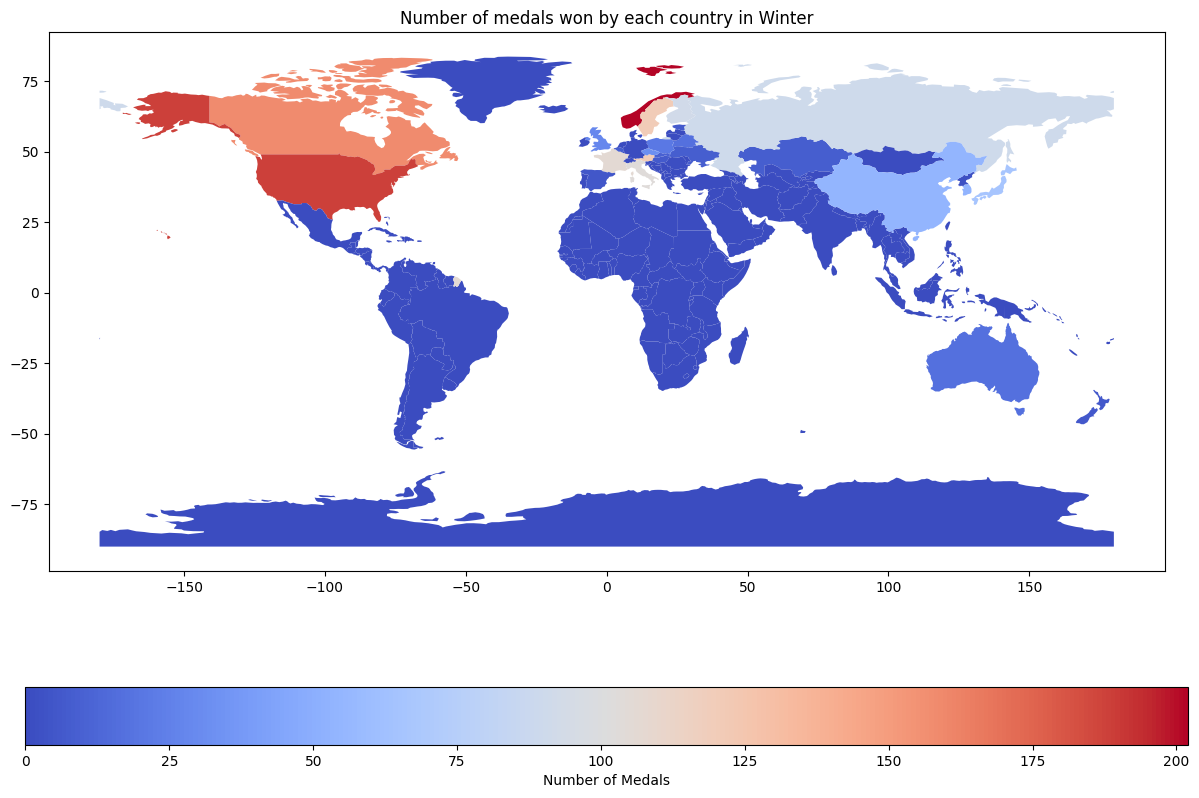

In [17]:
# Get the world geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

medals_by_country_winter.rename(columns={'country_3_letter_code': 'iso_a3'}, inplace=True)

world_medals = world.merge(medals_by_country_winter, how='left', on='iso_a3')

# Fill NaN values with 0
world_medals['count'] = world_medals['count'].fillna(0)

#plot result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_medals.plot(column='count', ax=ax, legend=True, cmap='coolwarm', 
                  legend_kwds={'label': "Number of Medals", 'orientation': "horizontal"})
plt.title('Number of medals won by each country in Winter')
plt.show()

## 2.4 Results

In [18]:
df_results.head(5)

,discipline_title,event_title,slug_game,participant_type,medal_type,athletes,rank_equal,rank_position,country_name,country_code,country_3_letter_code,athlete_url,athlete_full_name,value_unit,value_type
0,Curling,Mixed Doubles,beijing-2022,GameTeam,GOLD,"[('Stefania CONSTANTINI', 'https://olympics.co...",False,1,Italy,IT,ITA,NaN,NaN,NaN,NaN
1,Curling,Mixed Doubles,beijing-2022,GameTeam,SILVER,"[('Kristin SKASLIEN', 'https://olympics.com/en...",False,2,Norway,NO,NOR,NaN,NaN,NaN,NaN
2,Curling,Mixed Doubles,beijing-2022,GameTeam,BRONZE,"[('Almida DE VAL', 'https://olympics.com/en/at...",False,3,Sweden,SE,SWE,NaN,NaN,NaN,NaN
3,Curling,Mixed Doubles,beijing-2022,GameTeam,NaN,"[('Jennifer DODDS', 'https://olympics.com/en/a...",False,4,Great Britain,GB,GBR,NaN,NaN,NaN,NaN
4,Curling,Mixed Doubles,beijing-2022,GameTeam,NaN,"[('Rachel HOMAN', 'https://olympics.com/en/ath...",False,5,Canada,CA,CAN,NaN,NaN,NaN,NaN


In [19]:
df_results.describe()

,discipline_title,event_title,slug_game,participant_type,medal_type,athletes,rank_equal,rank_position,country_name,country_code,country_3_letter_code,athlete_url,athlete_full_name,value_unit,value_type
count,162804,162804,162804,162804,20206,7976,32526,158926,162804,157768,162804,129991,141646,78646,90049
unique,86,1567,53,2,3,6845,2,193,238,213,233,68104,75263,46475,12
top,Athletics,individual mixed,rio-2016,Athlete,BRONZE,"[('LETOT LETOT', 'https://olympics.com/en/athl...",True,9,United States of America,US,USA,https://olympics.com/en/athletes/heikki-savola...,Heikki SAVOLAINEN,same time,TIME
freq,19259,2731,7672,141646,7029,37,23613,8279,11916,11916,11916,34,34,99,43774


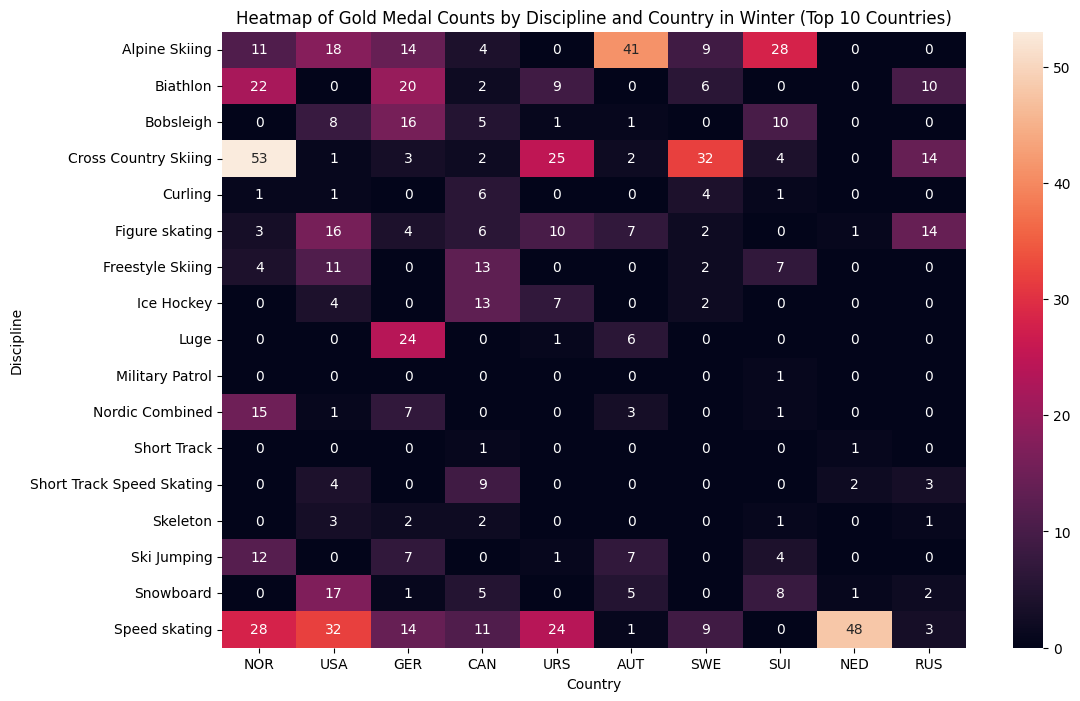

In [20]:
df_results_gold = df_results[df_results['rank_position'] == '1']
df_results_gold = df_results_gold.merge(df_hosts, left_on='slug_game', right_on='game_slug')

df_results_gold_summer = df_results_gold.query('game_season == "Summer"')
df_results_gold_winter = df_results_gold.query('game_season == "Winter"')

heatmap_summer = df_results_gold_summer.groupby(['discipline_title', 'country_3_letter_code']).size().unstack().fillna(0)
heatmap_winter = df_results_gold_winter.groupby(['discipline_title', 'country_3_letter_code']).size().unstack().fillna(0)

# Get the top 10 countries according to their number of medals
top_10_countries_summer = heatmap_summer.sum().nlargest(10).index
top_10_countries_winter = heatmap_winter.sum().nlargest(10).index

heatmap_summer = heatmap_summer[top_10_countries_summer]
heatmap_winter = heatmap_winter[top_10_countries_winter]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_winter, annot=True)
plt.title('Heatmap of Gold Medal Counts by Discipline and Country in Winter (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Discipline')
plt.show()

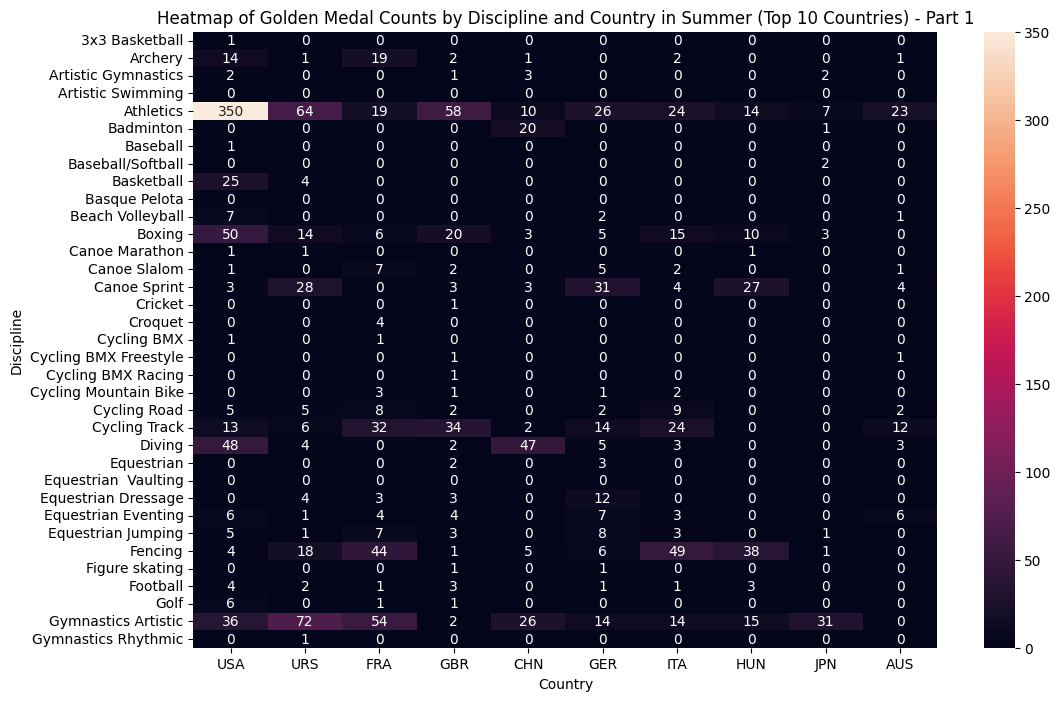

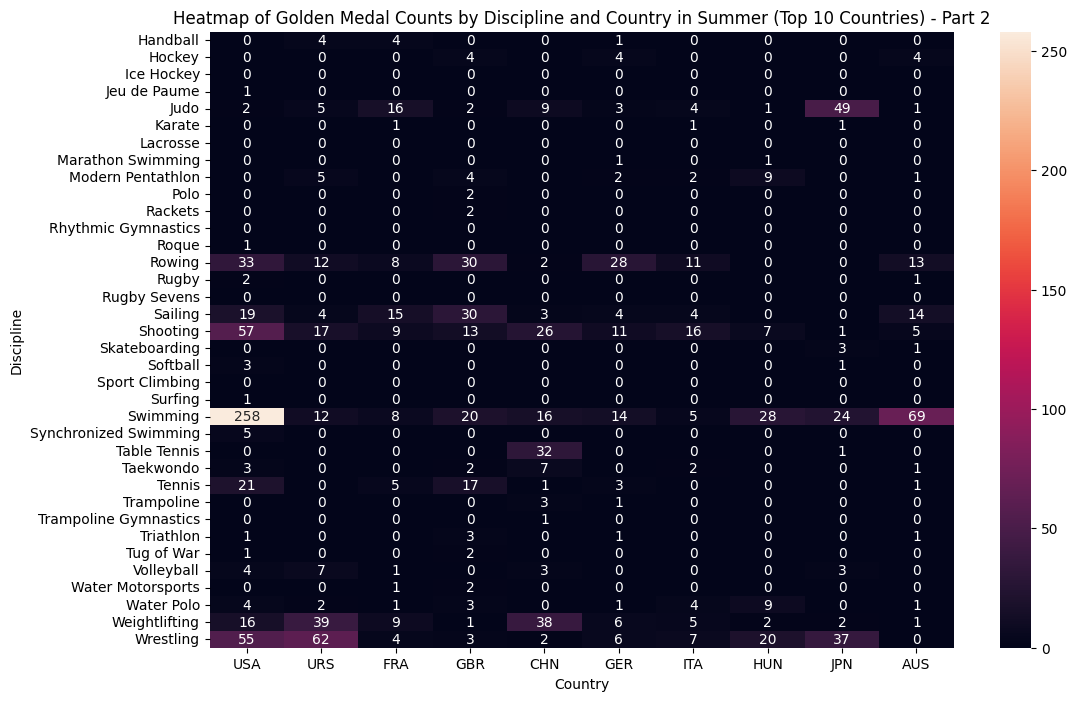

In [21]:
# Split the heatmap_summer DataFrame into two halves
half = len(heatmap_summer) // 2
heatmap_summer_1 = heatmap_summer.iloc[:half]
heatmap_summer_2 = heatmap_summer.iloc[half:]

# Create the first plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_summer_1, annot=True, fmt='.0f')
plt.title('Heatmap of Golden Medal Counts by Discipline and Country in Summer (Top 10 Countries) - Part 1')
plt.xlabel('Country')
plt.ylabel('Discipline')
plt.show()

# Create the second plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_summer_2, annot=True, fmt='.0f')
plt.title('Heatmap of Golden Medal Counts by Discipline and Country in Summer (Top 10 Countries) - Part 2')
plt.xlabel('Country')
plt.ylabel('Discipline')
plt.show()

In [22]:
df_results_merged = df_results.merge(df_hosts, left_on='slug_game', right_on='game_slug')
df_results_summer = df_results_merged.query('game_season == "Summer"')
df_results_winter = df_results_merged.query('game_season == "Winter"')

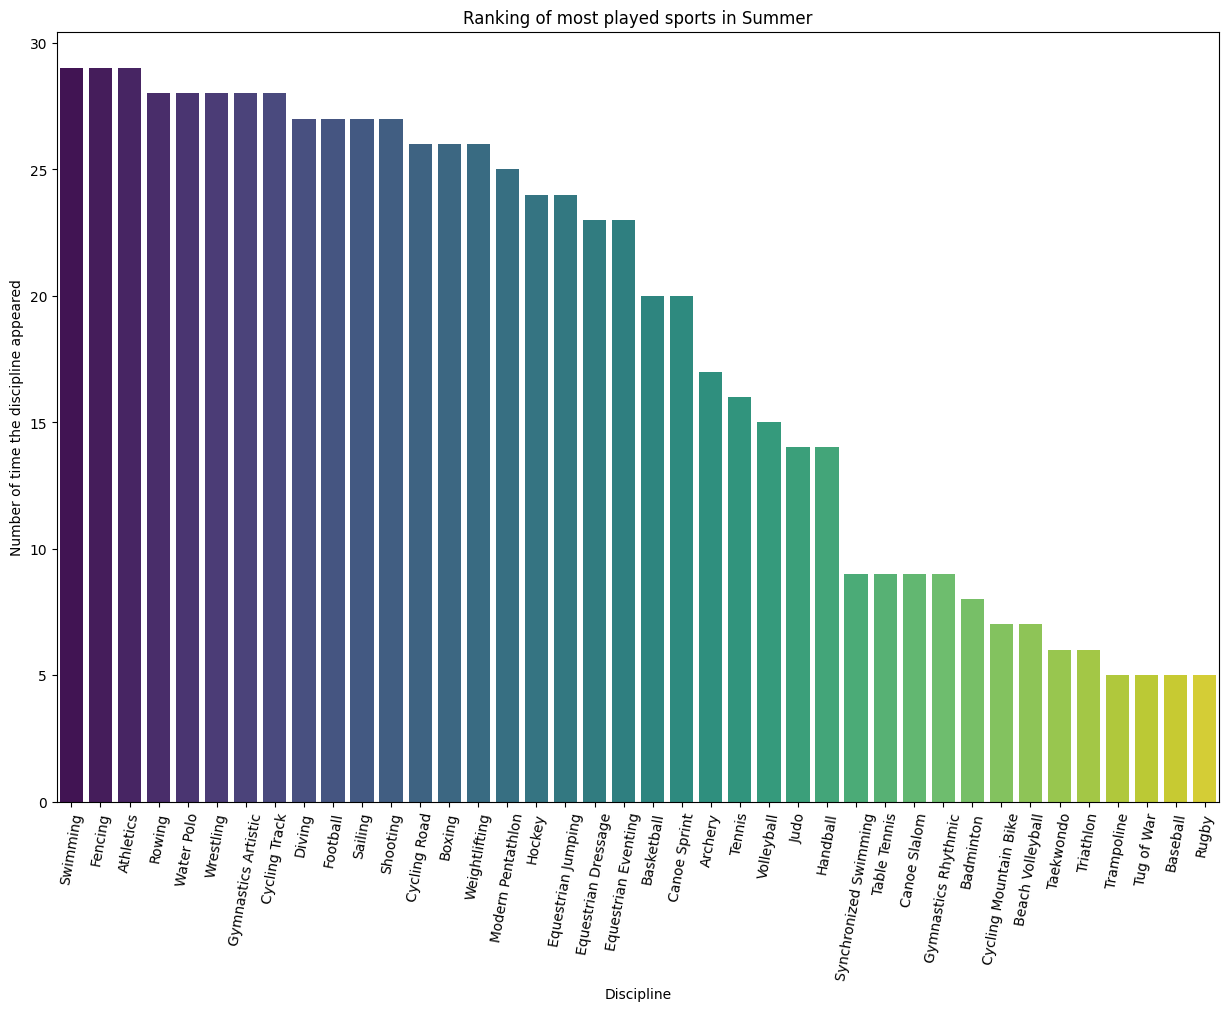

In [23]:
# Get the ranking of most played sports

# drop duplicates [discipline_title, slug_game]
df_results_unique_sport_per_game = df_results_summer.drop_duplicates(subset=['discipline_title', 'slug_game'])

most_played_sports = df_results_unique_sport_per_game['discipline_title'].value_counts().reset_index().sort_values(by='count', ascending=False)

# Plot the ranking of most played sports
plt.figure(figsize=(15, 10))
sns.barplot(data=most_played_sports.head(40), x='discipline_title', y='count', palette='viridis')
plt.title('Ranking of most played sports in Summer')
plt.xlabel('Discipline')
plt.ylabel('Number of time the discipline appeared')
plt.xticks(rotation=80)
plt.show()

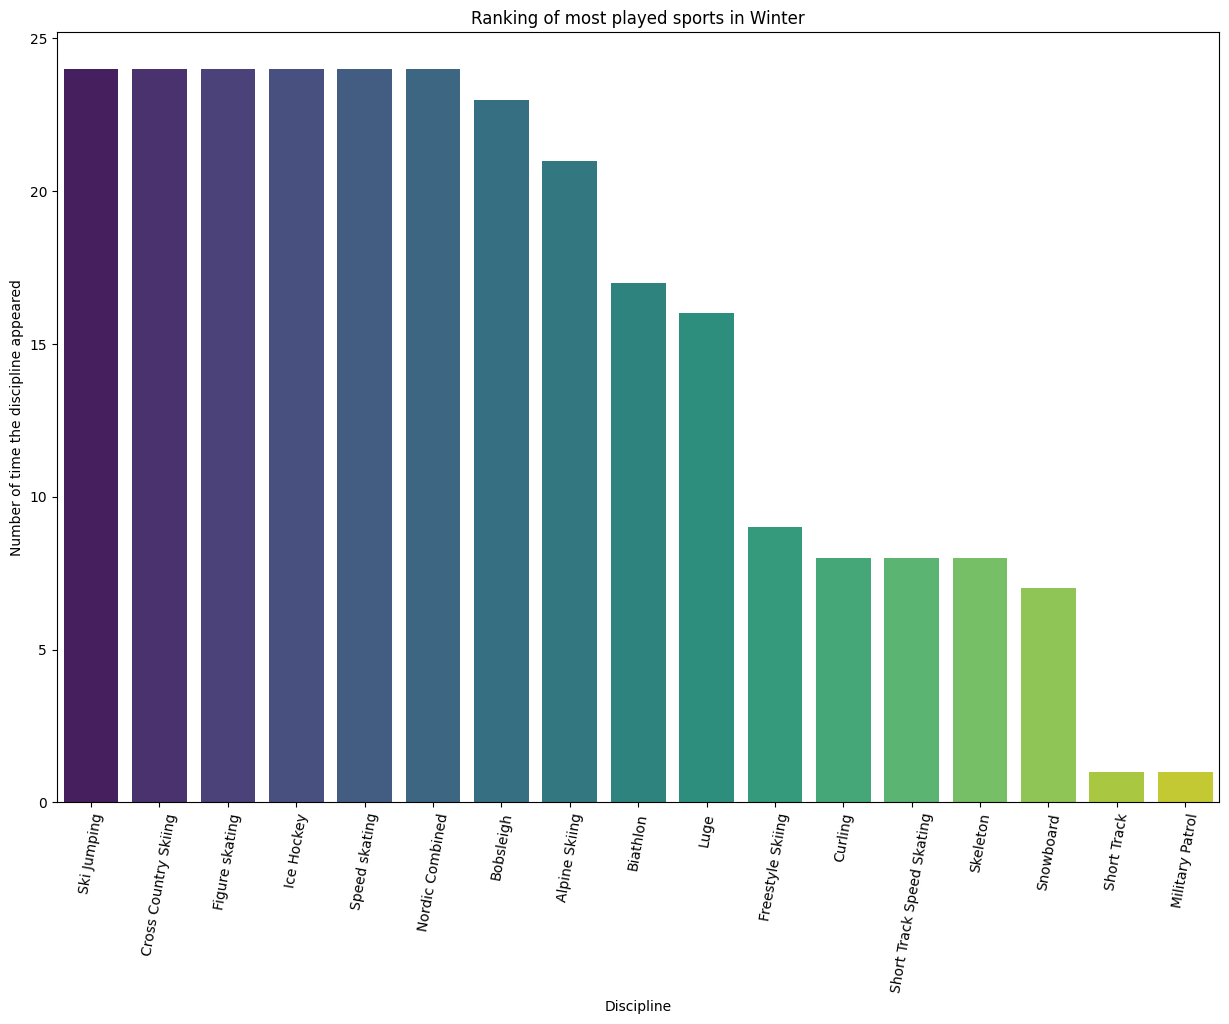

In [24]:
df_results_unique_sport_per_game = df_results_winter.drop_duplicates(subset=['discipline_title', 'slug_game'])

most_played_sports = df_results_unique_sport_per_game['discipline_title'].value_counts().reset_index().sort_values(by='count', ascending=False)

# Plot the ranking of most played sports
plt.figure(figsize=(15, 10))
sns.barplot(data=most_played_sports, x='discipline_title', y='count', palette='viridis')
plt.title('Ranking of most played sports in Winter')
plt.xlabel('Discipline')
plt.ylabel('Number of time the discipline appeared')
plt.xticks(rotation=80)
plt.show()

# 3 Create DataFrame

In [25]:
df_results = df_results.merge(df_medals)

In [26]:
df_medals.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022


In [49]:
cols_interest = ['rank_position','country_name','country_3_letter_code','medal_type','game_season']

df_medals_processed = deepcopy(df_results[cols_interest].groupby(['country_name','country_3_letter_code','medal_type','game_season']).count().reset_index())
df_medals_processed.rename(columns={'rank_position': 'count'}, inplace=True)
df_medals_processed = df_medals_processed.pivot(index=['country_name','country_3_letter_code','game_season'], columns='medal_type', values='count').fillna(0)
df_medals_processed = df_medals_processed[['GOLD','SILVER','BRONZE']].astype(int)
df_medals_processed.to_csv('../../data/olympic_medals_processed.csv', index=True)

# Find Top atletes for each country and web scrap their photo

In [61]:
df_athletes.head()

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000.0,NaN,NaN
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995.0,NaN,NaN
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993.0,NaN,NaN
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995.0,NaN,NaN
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989.0,NaN,NaN


In [90]:
df_athletes_country = df_athletes.merge(df_medals[['athlete_full_name', 'country_name','country_3_letter_code']], on='athlete_full_name')
df_athletes_country = df_athletes_country[['athlete_full_name', 'athlete_medals', 'country_name','country_3_letter_code', 'athlete_url']].drop_duplicates()
df_athletes_country['athlete_medals'] = df_athletes_country['athlete_medals'].fillna('0')
df_athletes_country['num_medals'] = df_athletes_country['athlete_medals'].apply(lambda x: sum([int(num) for num in re.findall(r'\d+', x)]))
df_athletes_country['num_medals'] = df_athletes_country['num_medals'].astype(int)
df_athletes_country['athlete_full_name_lower'] = df_athletes_country['athlete_full_name'].str.lower().apply(lambda x: x.replace(' ', '_'))
# drop column athlete_medals
df_athletes_country = df_athletes_country.drop(columns=['athlete_medals'])

In [91]:
# retrieve the top 10 athletes with the most medals
top_10_athletes = df_athletes_country.nlargest(10, 'num_medals')
top_10_athletes

,athlete_full_name,country_name,country_3_letter_code,athlete_url,num_medals,athlete_full_name_lower
3009,Michael PHELPS,United States of America,USA,https://olympics.com/en/athletes/michael-phelp...,28,michael_phelps
11510,Larisa LATYNINA,Soviet Union,URS,https://olympics.com/en/athletes/larisa-latynina,18,larisa_latynina
2139,Marit BJOERGEN,Norway,NOR,https://olympics.com/en/athletes/marit-bjoergen,15,marit_bjoergen
9250,Nikolay ANDRIANOV,Soviet Union,URS,https://olympics.com/en/athletes/nikolay-andri...,15,nikolay_andrianov
436,Ireen WÜST,Netherlands,NED,https://olympics.com/en/athletes/ireen-wust,13,ireen_wüst
3152,Ole Einar BJØRNDALEN,Norway,NOR,https://olympics.com/en/athletes/ole-einar-bjo...,13,ole_einar_bjørndalen
4612,Takashi ONO,Japan,JPN,https://olympics.com/en/athletes/takashi-ono,13,takashi_ono
11530,Boris SHAKHLIN,Soviet Union,URS,https://olympics.com/en/athletes/boris-shakhlin,13,boris_shakhlin
12391,Edoardo MANGIAROTTI,Italy,ITA,https://olympics.com/en/athletes/edoardo-mangi...,13,edoardo_mangiarotti
1476,Isabell WERTH,Germany,GER,https://olympics.com/en/athletes/isabell-werth,12,isabell_werth


In [92]:
# For each country get the top athlete with the most medals
top_athlete_country = df_athletes_country.groupby('country_name')['num_medals'].idxmax()
top_athlete_country = df_athletes_country.loc[top_athlete_country]
top_athlete_country = top_athlete_country.sort_values(by='num_medals', ascending=False)
# save the result
top_athlete_country.to_csv('../../data/olympic_top_athlete_per_country.csv', index=True)
top_athlete_country

,athlete_full_name,country_name,country_3_letter_code,athlete_url,num_medals,athlete_full_name_lower
3009,Michael PHELPS,United States of America,USA,https://olympics.com/en/athletes/michael-phelp...,28,michael_phelps
11510,Larisa LATYNINA,Soviet Union,URS,https://olympics.com/en/athletes/larisa-latynina,18,larisa_latynina
2139,Marit BJOERGEN,Norway,NOR,https://olympics.com/en/athletes/marit-bjoergen,15,marit_bjoergen
436,Ireen WÜST,Netherlands,NED,https://olympics.com/en/athletes/ireen-wust,13,ireen_wüst
4612,Takashi ONO,Japan,JPN,https://olympics.com/en/athletes/takashi-ono,13,takashi_ono
...,...,...,...,...,...,...
1933,Tareg HAMEDI,Saudi Arabia,KSA,https://olympics.com/en/athletes/tareg-hamedi,1,tareg_hamedi
1288,Nora GJAKOVA,Kosovo,KOS,https://olympics.com/en/athletes/nora-gjakova,1,nora_gjakova
7239,Hussein AHMED SALAH,Djibouti,DJI,https://olympics.com/en/athletes/hussein-ahmed...,1,hussein_ahmed_salah
1873,Pavlos KONTIDES,Cyprus,CYP,https://olympics.com/en/athletes/pavlos-kontides,1,pavlos_kontides


In [4]:
# Function to scrape image from URL
def scrape_image(url, athlete_name):
    driver = webdriver.Chrome() 
    print(f"Scraping image from URL: {url}")
    try:
        # Open the URL in the browser
        driver.get(url)
        time.sleep(2)  # Wait for the page to load

        # Find the image element using XPath
        img_element = driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/section[1]/div[1]/div[1]/div/div/div/picture/img')
        # Get the source URL of the image
        img_url = img_element.get_attribute('src')
        
        # Send a GET request to the image URL
        img_response = requests.get(img_url, stream=True)
        
        # Check if the request was successful
        if img_response.status_code == 200:
            # Save the image locally
            with open(f'../../data/image_athletes/{athlete_name}.jpg', 'wb') as f:
                f.write(img_response.content)
        
            print("Image scraped successfully!")
        else:
            print("Failed to fetch image")
        
        # print("Image scraped successfully!")
    except Exception as e:
        print("Failed to scrape image:", e)
    finally:
        # Close the browser window
        driver.quit()

In [5]:
from tqdm import tqdm
# load csv
top_athlete_country = pd.read_csv('../../data/olympic_top_athlete_per_country.csv')
# Scraping images for the top athletes
for i, row in tqdm(top_athlete_country.iterrows(), total=len(top_athlete_country)):
    athlete_name = row['athlete_full_name_lower']
    # don't scrape if the image already exists
    if os.path.exists(f'../../data/image_athletes/{athlete_name}.jpg'):
        print(f"Image for {athlete_name} already exists")
        continue
    athlete_url = row['athlete_url']
    scrape_image(athlete_url, athlete_name)

  0%|          | 0/149 [00:00<?, ?it/s]

Image for michael_phelps already exists
Image for larisa_latynina already exists
Image for marit_bjoergen already exists


Scraping image from URL: https://olympics.com/en/athletes/ireen-wust
Image scraped successfully!


  3%|▎         | 4/149 [00:40<24:24, 10.10s/it]

Image for takashi_ono already exists
Scraping image from URL: https://olympics.com/en/athletes/edoardo-mangiarotti
Failed to scrape image: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[2]/section[1]/div[1]/div[1]/div/div/div/picture/img"}
  (Session info: chrome=123.0.6312.124); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF789367032+63090]
	(No symbol) [0x00007FF7892D2C82]
	(No symbol) [0x00007FF78916EC65]
	(No symbol) [0x00007FF7891B499D]
	(No symbol) [0x00007FF7891B4ADC]
	(No symbol) [0x00007FF7891F5B37]
	(No symbol) [0x00007FF7891D701F]
	(No symbol) [0x00007FF7891F3412]
	(No symbol) [0x00007FF7891D6D83]
	(No symbol) [0x00007FF7891A83A8]
	(No symbol) [0x00007FF7891A9441]
	GetHandleVerifier [0x00007FF7897625AD+4238317]
	GetHandleVerifier [0x00007FF78979F70D+4488525]
	GetHandleVerifier [0x0

  4%|▍         | 6/149 [00:59<23:30,  9.87s/it]

Scraping image from URL: https://olympics.com/en/athletes/birgit-fischer
Image scraped successfully!


  5%|▍         | 7/149 [01:15<26:29, 11.19s/it]

Scraping image from URL: https://olympics.com/en/athletes/paavo-nurmi
Image scraped successfully!


  5%|▌         | 8/149 [01:34<30:52, 13.14s/it]

Scraping image from URL: https://olympics.com/en/athletes/isabell-werth
Image scraped successfully!


  6%|▌         | 9/149 [01:52<33:33, 14.38s/it]

Scraping image from URL: https://olympics.com/en/athletes/alexei-nemov
Image scraped successfully!


  7%|▋         | 10/149 [02:10<35:35, 15.36s/it]

Scraping image from URL: https://olympics.com/en/athletes/emma-mckeon


  7%|▋         | 10/149 [02:24<33:28, 14.45s/it]


KeyboardInterrupt: 